Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import random

In [93]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./dataset/Train/")
data_dir_test = pathlib.Path('./dataset/Test/')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [96]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [97]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [107]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

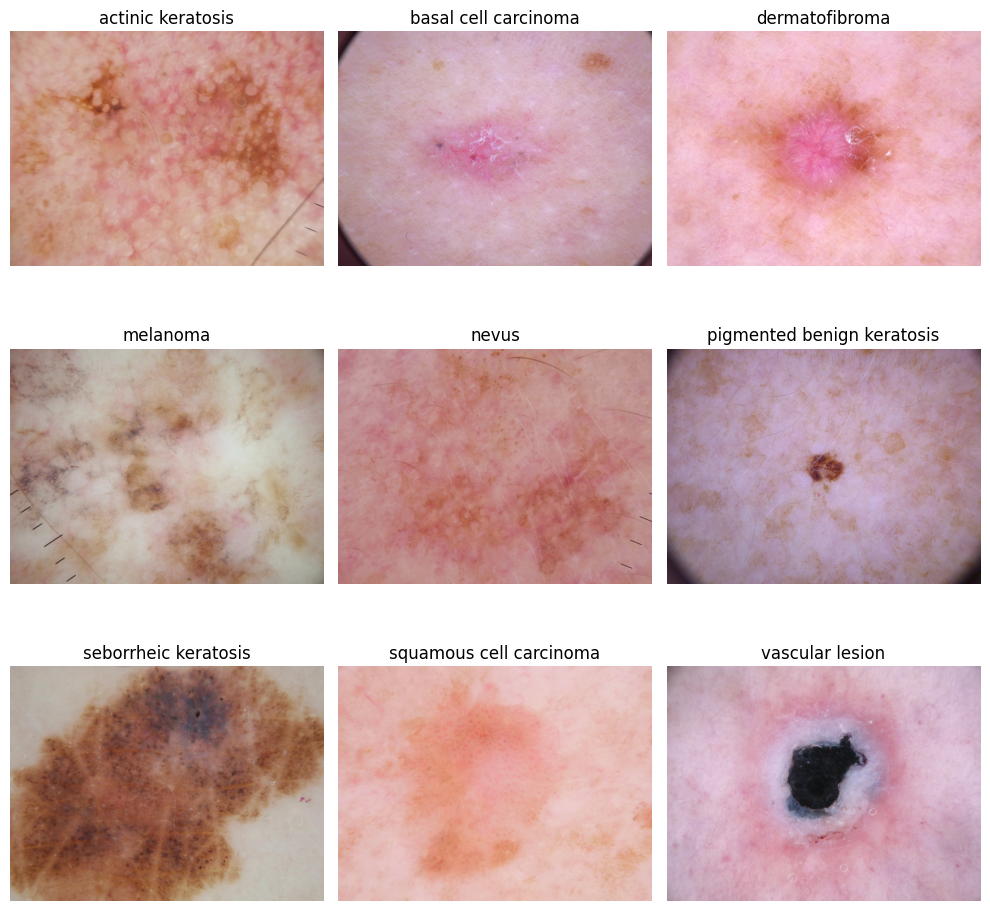

In [ ]:
# Create a figure to hold the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

# Loop through the class names and plot one image from each class
for i, class_name in enumerate(class_names):
    # Get the path to a random image from this class
    class_dir = os.path.join(data_dir_train, class_name)
    img_path = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_path)
    
    # Load the image
    img = plt.imread(img_path)
    
    # Plot the image on the corresponding subplot
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# Use the Rescaling layer to normalize the pixel values of the images
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
rescale_layer = Rescaling(scale=1./255)

# Apply the rescaling layer to the images in the training dataset
train_ds = train_ds.map(lambda x, y: (rescale_layer(x), y))

# Apply the rescaling layer to the images in the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale_layer(x), y))

In [ ]:
# Define the input shape of the images
input_shape = (180, 180, 3)

In [ ]:
# Define the number of classes in the dataset
num_classes = 9

In [108]:
model = Sequential()

# add convolutional layers
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# add dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [109]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 20, 20, 128)     

### Train the model

In [111]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 98s 569ms/step - loss: 14.9237 - accuracy: 0.2083 - val_loss: 1.9690 - val_accuracy: 0.2717
Epoch 2/20
169/169 [==============================] - 102s 603ms/step - loss: 1.8613 - accuracy: 0.2967 - val_loss: 1.8060 - val_accuracy: 0.3125
Epoch 3/20
169/169 [==============================] - 90s 529ms/step - loss: 1.6359 - accuracy: 0.4013 - val_loss: 1.7064 - val_accuracy: 0.3846
Epoch 4/20
169/169 [==============================] - 93s 547ms/step - loss: 1.3567 - accuracy: 0.5106 - val_loss: 1.4642 - val_accuracy: 0.5063
Epoch 5/20
169/169 [==============================] - 114s 670ms/step - loss: 1.1629 - accuracy: 0.5912 - val_loss: 1.4914 - val_accuracy: 0.5301
Epoch 6/20
169/169 [==============================] - 111s 649ms/step - loss: 0.9692 - accuracy: 0.6586 - val_loss: 1.3210 - val_accuracy: 0.6073
Epoch 7/20
169/169 [==============================] - 92s 538ms/step - loss: 0.7539 - accuracy: 0.7400 - val_loss: 1.2082 - va

### Visualizing training results

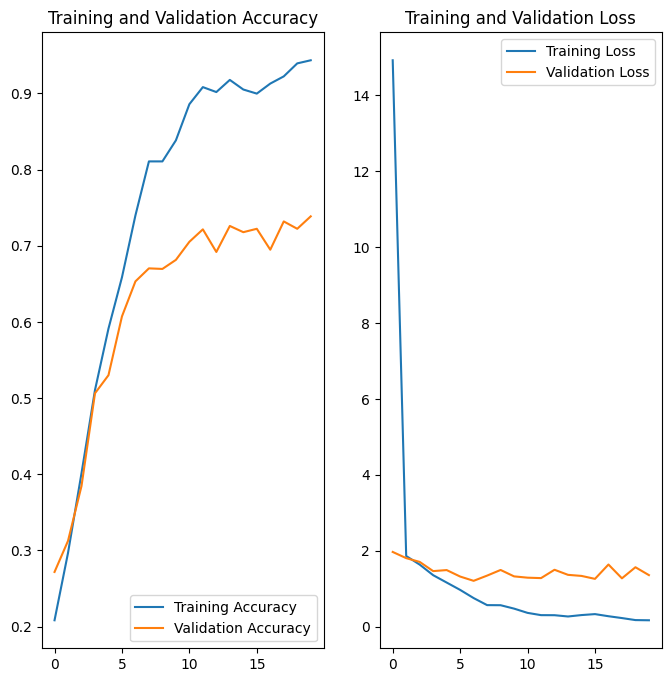

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The model seems to be overfitting as the accuracy on the training set is high, but the accuracy on the validation set is quite low. 

In [7]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
  layers.Resizing(img_width, img_height),
  layers.Rescaling(1./255)
])

# Load the original image data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

# apply the data augmentation to the training dataset
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# apply the data augmentation to the validation dataset
val_ds_augmented = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 11239 files belonging to 9 classes.
Using 8992 files for training.


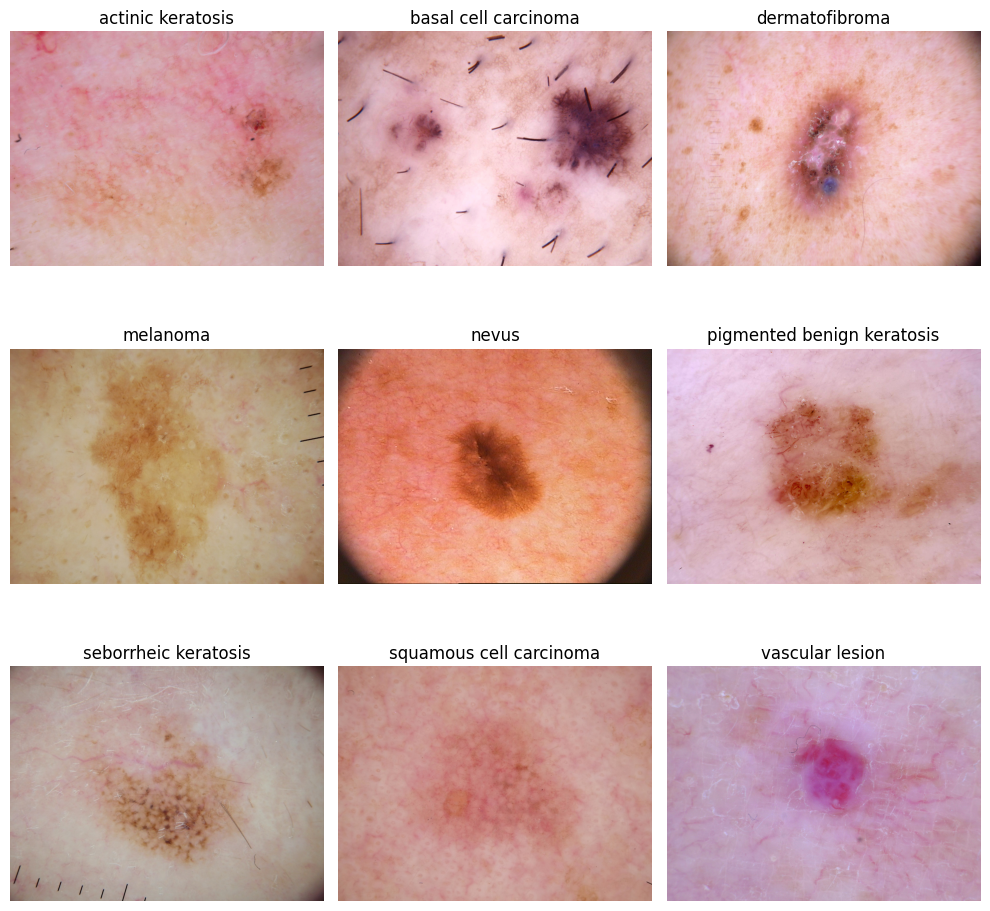

In [124]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Create a figure to hold the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

# Loop through the class names and plot one image from each class
for i, class_name in enumerate(class_names):
    # Get the path to a random image from this class
    class_dir = os.path.join(data_dir_train, class_name)
    img_path = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_path)
    
    # Load the image
    img = plt.imread(img_path)
    
    # Transform the image
    transformed_image = data_augmentation(img)

    # Plot the image on the corresponding subplot
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [125]:
model = Sequential()

# add convolutional layers
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# add dropout layer
model.add(Dropout(0.5))

# add dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))



### Compiling the model

In [126]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [127]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds_augmented,
  validation_data=val_ds_augmented,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 82s 477ms/step - loss: 1.9947 - accuracy: 0.2455 - val_loss: 1.6663 - val_accuracy: 0.3719
Epoch 2/20
169/169 [==============================] - 87s 509ms/step - loss: 1.5994 - accuracy: 0.3930 - val_loss: 1.4749 - val_accuracy: 0.4454
Epoch 3/20
169/169 [==============================] - 90s 527ms/step - loss: 1.4624 - accuracy: 0.4445 - val_loss: 1.4576 - val_accuracy: 0.4521
Epoch 4/20
169/169 [==============================] - 93s 546ms/step - loss: 1.4156 - accuracy: 0.4555 - val_loss: 1.3499 - val_accuracy: 0.4692
Epoch 5/20
169/169 [==============================] - 95s 559ms/step - loss: 1.3617 - accuracy: 0.4770 - val_loss: 1.4276 - val_accuracy: 0.4566
Epoch 6/20
169/169 [==============================] - 95s 560ms/step - loss: 1.3386 - accuracy: 0.4790 - val_loss: 1.2449 - val_accuracy: 0.5301
Epoch 7/20
169/169 [==============================] - 96s 564ms/step - loss: 1.2743 - accuracy: 0.5117 - val_loss: 1.2020 - val_ac

### Visualizing the results

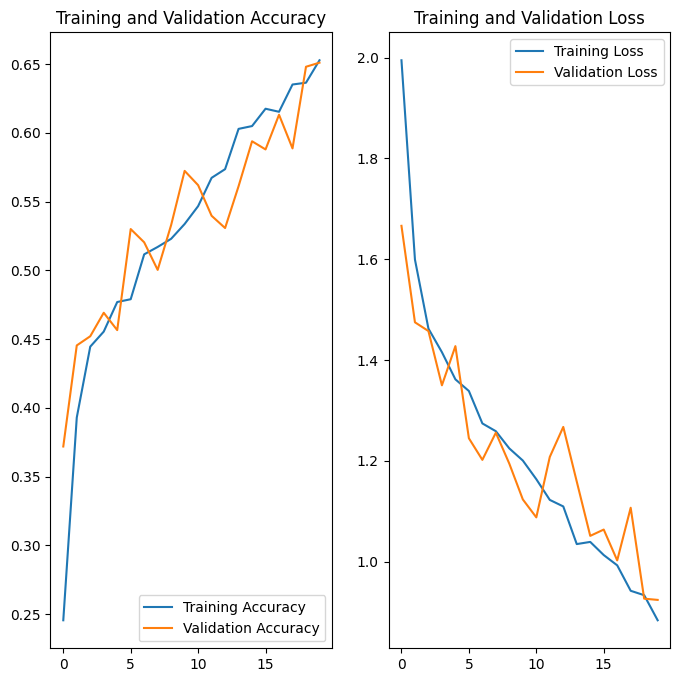

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The issue of overfitting seems to have been addressed. The training accuracy  and validation accuracy are in line with each other. However the overall accuracy of the model has dropped.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

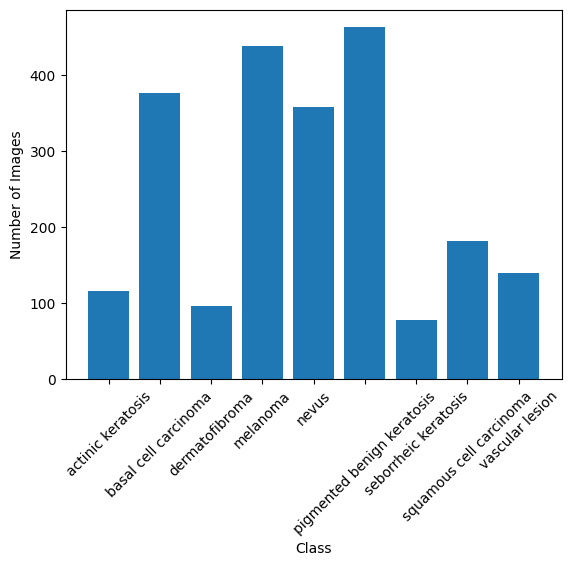

In [129]:
## Your code goes here.
# Get the number of images in each class
num_images = []
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    num_images.append(len(os.listdir(class_path)))

# Plot a bar chart of the distribution of classes
plt.bar(class_names, num_images)
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


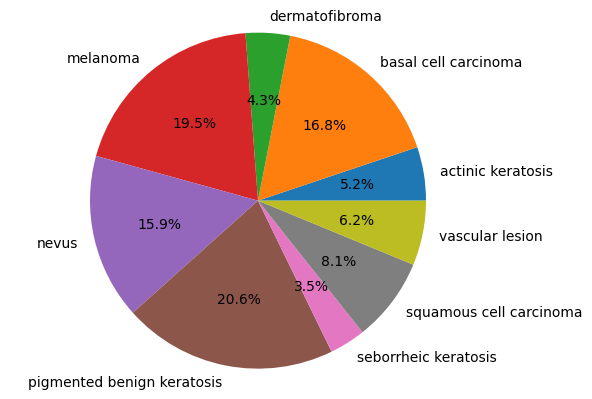

In [130]:
# Plot a pie chart of the distribution of classes
plt.pie(num_images, labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
The class "seborrheic keratosis" has the least number of samples in the dataset 
#### - Which classes dominate the data in terms proportionate number of samples?
The classes "melanoma", "nevus", "pigmented benign keratosis" dominate the dataset.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip3 install Augmentor

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [131]:
path_to_training_dataset="./dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2931D9D80>: 100%|██████████| 500/500 [00:02<00:00, 191.04 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to ./dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x293240B80>: 100%|██████████| 500/500 [00:02<00:00, 229.52 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ./dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x290664B50>: 100%|██████████| 500/500 [00:02<00:00, 210.53 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ./dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x292899C60>: 100%|██████████| 500/500 [00:10<00:00, 45.72 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to ./dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29086AD70>: 100%|██████████| 500/500 [00:10<00:00, 49.45 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to ./dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x292C0BA60>: 100%|██████████| 500/500 [00:02<00:00, 211.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./dataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x293937670>: 100%|██████████| 500/500 [00:05<00:00, 97.48 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to ./dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x292A9D1B0>: 100%|██████████| 500/500 [00:02<00:00, 208.77 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ./dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x292A90A90>: 100%|██████████| 500/500 [00:02<00:00, 194.19 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [132]:
from glob import glob


path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['dataset/Train/melanoma/output/melanoma_original_ISIC_0010145.jpg_fd52f591-2789-4be7-b00a-797c8aea7ff5.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0000151.jpg_1f897ace-eed6-4de7-a963-310c86d060ce.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010164.jpg_b581debe-5c6f-475f-826e-a5f892f5d8c4.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010942.jpg_26808126-9d08-48f4-aade-85c220348b01.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010388.jpg_372cf999-e85e-4f6b-b5fc-4744e7b0edfc.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010860.jpg_565ba0d8-419b-47d5-be4a-f571c4a36599.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010360.jpg_bba1b675-7496-4bb2-afb7-f836c8dcc3fb.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0000482.jpg_3e612d2f-78f8-4339-a027-dc320e1e1d55.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0011112.jpg_cb59fe8c-46e5-447a-9f80-a445d1369348.jpg',
 'dataset/

In [133]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [134]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [135]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [136]:
df2['Label'].value_counts()

melanoma                      1000
pigmented benign keratosis    1000
nevus                         1000
basal cell carcinoma          1000
actinic keratosis             1000
squamous cell carcinoma       1000
vascular lesion               1000
seborrheic keratosis          1000
dermatofibroma                1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [3]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [4]:
data_dir_train="./dataset/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [8]:
# apply the data augmentation to the training dataset
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# apply the data augmentation to the validation dataset
val_ds_augmented = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

#### **Todo:** Create your model (make sure to include normalization)

In [9]:
# create the model
model = Sequential()

# add convolutional layers with batch normalization
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# add dropout layer
model.add(Dropout(0.5))

# add dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)     

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [11]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds_augmented,
  validation_data=val_ds_augmented,
  epochs=epochs
)

#### **Todo:**  Visualize the model results

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Underfittng and overfitting seems to have been addressed. Both training accuracy and validation accuracy are going hand in hand. Although the overall accuracy is decent at 80%, maybe there's still room for improvement.

Let's try with 50 epochs

In [13]:
# create the model
model = Sequential()

# add convolutional layers with batch normalization
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# add dropout layer
model.add(Dropout(0.5))

# add dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 128)     

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
epochs = 50
history = model.fit(
  train_ds_augmented,
  validation_data=val_ds_augmented,
  epochs=epochs
)

Epoch 1/50


2023-05-07 05:30:52.537905: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


281/281 [==============================] - 115s 406ms/step - loss: 1.7851 - accuracy: 0.3176 - val_loss: 1.4540 - val_accuracy: 0.4117
Epoch 2/50
281/281 [==============================] - 594s 2s/step - loss: 1.4471 - accuracy: 0.4366 - val_loss: 1.3024 - val_accuracy: 0.5042
Epoch 3/50
281/281 [==============================] - 120s 425ms/step - loss: 1.3064 - accuracy: 0.4865 - val_loss: 1.2728 - val_accuracy: 0.4998
Epoch 4/50
281/281 [==============================] - 124s 438ms/step - loss: 1.2766 - accuracy: 0.5017 - val_loss: 1.2682 - val_accuracy: 0.5073
Epoch 5/50
281/281 [==============================] - 126s 445ms/step - loss: 1.2089 - accuracy: 0.5198 - val_loss: 1.1091 - val_accuracy: 0.5674
Epoch 6/50
281/281 [==============================] - 127s 451ms/step - loss: 1.1507 - accuracy: 0.5519 - val_loss: 1.1369 - val_accuracy: 0.5701
Epoch 7/50
281/281 [==============================] - 129s 458ms/step - loss: 1.0863 - accuracy: 0.5763 - val_loss: 1.0214 - val_accuracy:

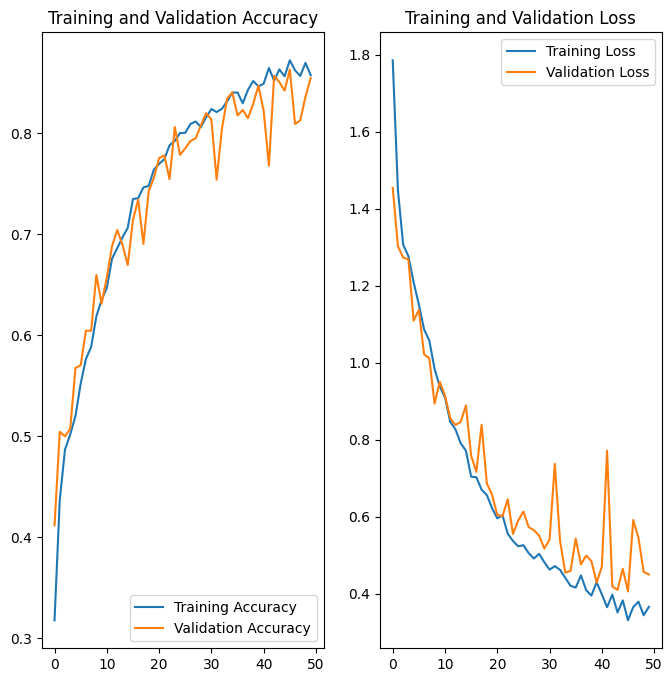

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

With 50 epochs we have a very good model with training accuracy of 0.85 and validation accuracy of 0.85. 

Throughout the epoch journeys, it is noticed that the training and validation acuuracy went hand in hand. The above graphs suggest the same. 

In conclusion, data augmentation, rectifying class imbalance, and using a dropout layer helped achieve a greater accuracy.